In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregar os dados
ratings_df = pd.read_csv('/content/ratings.csv')
movies_df = pd.read_csv('/content/movies.csv')

In [3]:
print("Colunas de ratings:", ratings_df.columns)
print("Colunas de movies:", movies_df.columns)

Colunas de ratings: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Colunas de movies: Index(['movieId', 'title', 'genres'], dtype='object')


# Estrutura do Arquivo de ratings

Os usuários do MovieLens foram selecionados aleatoriamente para inclusão. Seus IDs foram anonimizados. Os IDs de usuário são consistentes entre ratings.csv e tags.csv (ou seja, o mesmo ID se refere ao mesmo usuário nos dois arquivos).

Apenas filmes com pelo menos uma classificação ou tag são incluídos no conjunto de dados. Esses IDs de filmes são consistentes com os usados ​​no site do MovieLens (por exemplo, o ID `1` corresponde à URL <https://movielens.org/movies/1>). Os IDs de filmes são consistentes entre `ratings.csv`, `tags.csv`, `movies.csv` e `links.csv` (ou seja, o mesmo ID se refere ao mesmo filme nesses quatro arquivos de dados).

Todas as classificações estão contidas no arquivo `ratings.csv`. Cada linha deste arquivo após a linha de cabeçalho representa uma avaliação de um filme por um usuário e tem o seguinte formato:

userId,movieId,rating,timestamp

As linhas dentro deste arquivo são ordenadas primeiro por userId e, em seguida, dentro de user, por movieId.

As classificações são feitas em uma escala de 5 estrelas, com incrementos de meia estrela (0,5 estrela - 5,0 estrelas).

Os timestamps representam segundos desde a meia-noite do Tempo Universal Coordenado (UTC) de 1º de janeiro de 1970.

In [4]:
ratings_df

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077.0
1,1,25,1.0,944250228.0
2,1,29,2.0,943230976.0
3,1,30,5.0,944249077.0
4,1,32,5.0,943228858.0
...,...,...,...,...
288956,1848,2028,5.0,970708187.0
288957,1848,2060,1.0,970710522.0
288958,1848,2076,4.0,970711329.0
288959,1848,2124,3.0,970709453.0


# Estrutura do Arquivo de Dados de Filmes (movies.csv)

As informações do filme estão contidas no arquivo `movies.csv`. Cada linha deste arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato:

movieId,título,gêneros

Os títulos dos filmes são inseridos manualmente ou importados de <https://www.themoviedb.org/> e incluem o ano de lançamento entre parênteses. Podem existir erros e inconsistências nesses títulos.

Os gêneros são uma lista separada por barras verticais.

In [5]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [6]:
ratings_df.dropna(inplace=True)
movies_df.dropna(inplace=True)

# Agora, vamos analisar a frequência de avaliações por usuário.

Distribuição do número de avaliações por usuário:


,count
count,1848.000000
mean,156.363636
std,255.728954
min,20.000000
25%,36.000000
50%,73.000000
75%,157.000000
max,3527.000000


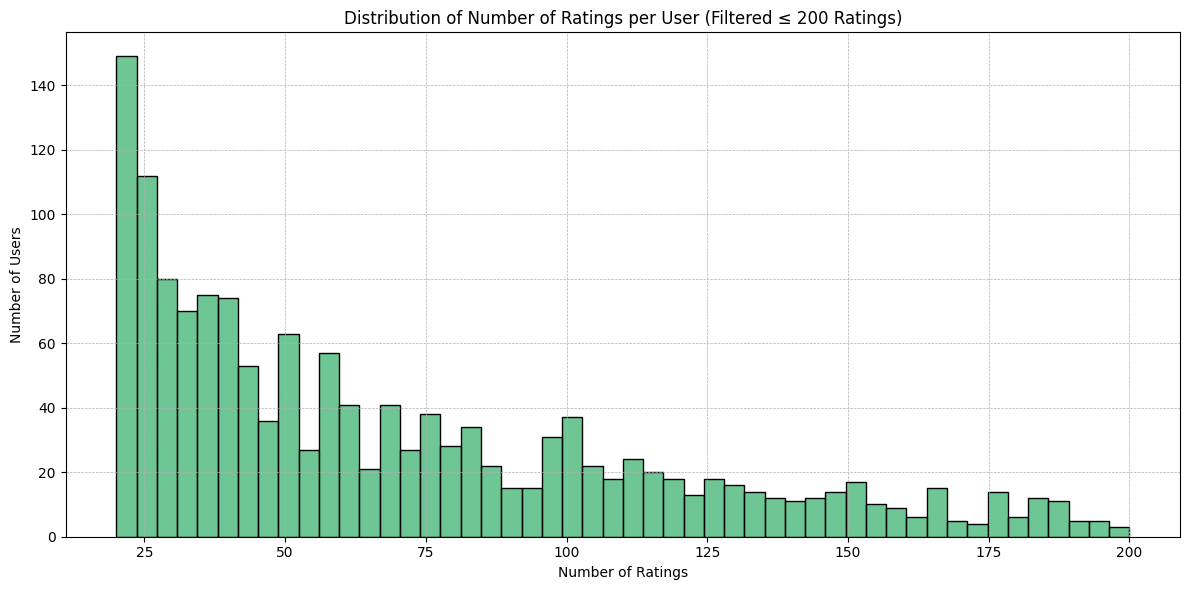

In [7]:
user_ratings_counts = ratings_df['userId'].value_counts()
print("Distribuição do número de avaliações por usuário:")
display(user_ratings_counts.describe())

filtered_counts = user_ratings_counts[user_ratings_counts <= 200]

plt.figure(figsize=(12, 6))
sns.histplot(filtered_counts, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Distribution of Number of Ratings per User (Filtered ≤ 200 Ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Distribuição de Avaliações por Usuário (≤ 200 avaliações)

- A maioria dos usuários faz poucas avaliações, com pico entre 20 e 30.
- À medida que o número de avaliações aumenta, a quantidade de usuários diminui.
- Poucos usuários são altamente ativos.
- O comportamento mostra um uso majoritariamente casual do sistema.


# Em seguida, analisaremos a frequência de avaliações por filme.


Distribuição do número de avaliações por filme:


,count
count,17433.000000
mean,16.575460
std,50.224947
min,1.000000
25%,1.000000
50%,2.000000
75%,9.000000
max,952.000000


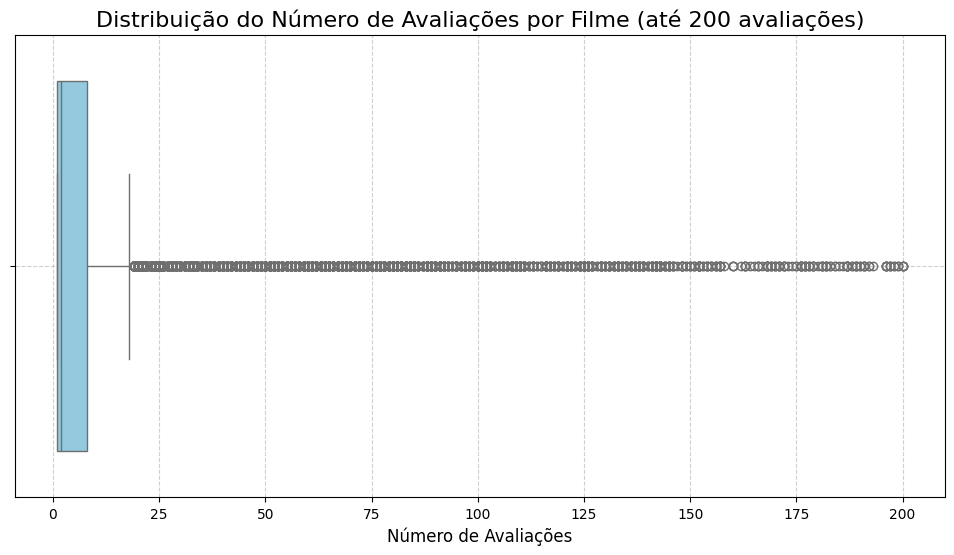

In [8]:
movie_ratings_counts = ratings_df['movieId'].value_counts()
print("\nDistribuição do número de avaliações por filme:")
display(movie_ratings_counts.describe())

filtered_movie_ratings = movie_ratings_counts[movie_ratings_counts <= 200]

plt.figure(figsize=(12, 6))
sns.boxplot(x=filtered_movie_ratings, color='skyblue')
plt.title('Distribuição do Número de Avaliações por Filme (até 200 avaliações)', fontsize=16)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

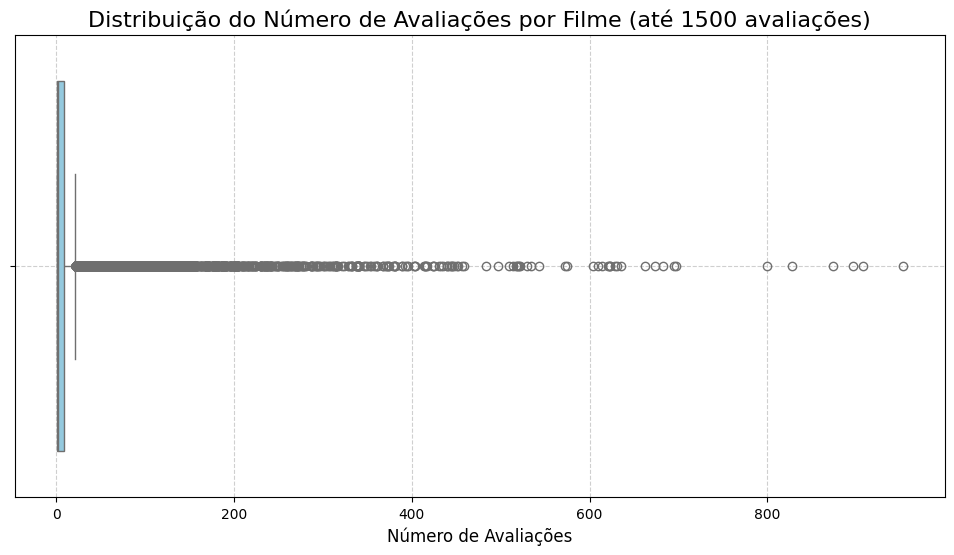

In [9]:
filtered_movie_ratings = movie_ratings_counts[movie_ratings_counts <= 1500]

plt.figure(figsize=(12, 6))
sns.boxplot(x=filtered_movie_ratings, color='skyblue')
plt.title('Distribuição do Número de Avaliações por Filme (até 1500 avaliações)', fontsize=16)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

O boxplot acima ilustra a distribuição do número de avaliações que cada filme recebeu, com um foco em filmes que têm até 1500 avaliações.

Concentração de Dados: A "caixa" no boxplot, que representa o intervalo interquartil (IQR), é muito estreita e próxima de zero. Isso indica que 50% dos filmes (entre o 25º e o 75º percentil) receberam um número muito baixo de avaliações.

Mediana: A linha dentro da caixa (mediana) também está muito próxima de zero, reforçando a ideia de que a maioria dos filmes tem pouquíssimas avaliações.

Outliers: Os pontos individuais à direita da "caixa" são considerados outliers. Eles representam filmes que receberam um número de avaliações significativamente maior do que a maioria. Isso mostra que, embora a maioria dos filmes seja pouco avaliada, um pequeno número de filmes é extremamente popular e atrai um grande volume de avaliações.

Em resumo, o gráfico evidencia uma cauda longa na popularidade dos filmes: a grande maioria dos filmes tem pouca ou nenhuma avaliação, enquanto um pequeno número de filmes domina as discussões e o engajamento dos usuários.

# Agora visualizando o número de classificações ao longo do tempo.

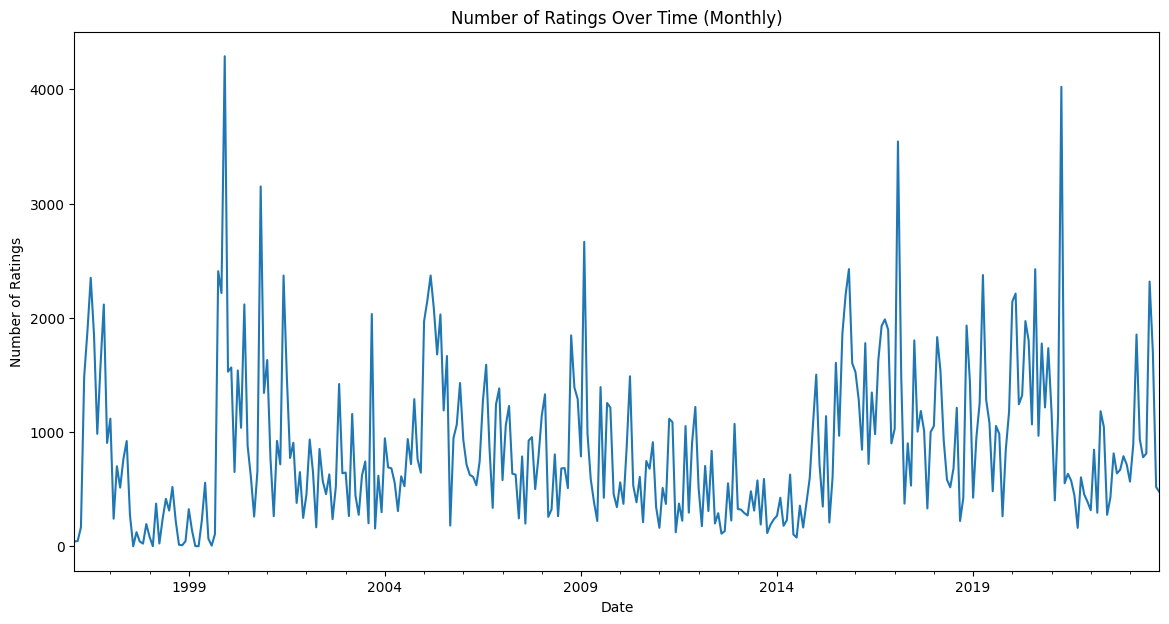

In [10]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

plt.figure(figsize=(14, 7))
ratings_df.set_index('timestamp').resample('ME')['rating'].count().plot()
plt.title('Number of Ratings Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()

### Interpretação dos Gráficos: Avaliações de Filmes

#### 1. Número de Avaliações ao Longo do Tempo (Gráfico de Linha)
- O gráfico mostra **picos acentuados entre 1997 e 2004**, com destaque para 1999, onde o número de avaliações mensais ultrapassou 400.000.
- Após 2004, há uma **tendência geral de queda e estabilização** no número de avaliações mensais.
- Alguns **picos posteriores** ocorrem esporadicamente, como por volta de 2013–2015.
- Isso pode indicar mudanças no uso da plataforma de avaliações ou na coleta dos dados ao longo do tempo.

## Explorar o dataframe `movies df`

Analisar a distribuição de filmes por ano de lançamento (extraindo o ano do título). Explorar a distribuição de gêneros (`genres`). Identificar filmes com títulos duplicados ou formatos de título incomuns.

Para analisar a distribuição de filmes por ano de lançamento, preciso extrair o ano da coluna 'título' e então visualizar sua distribuição.

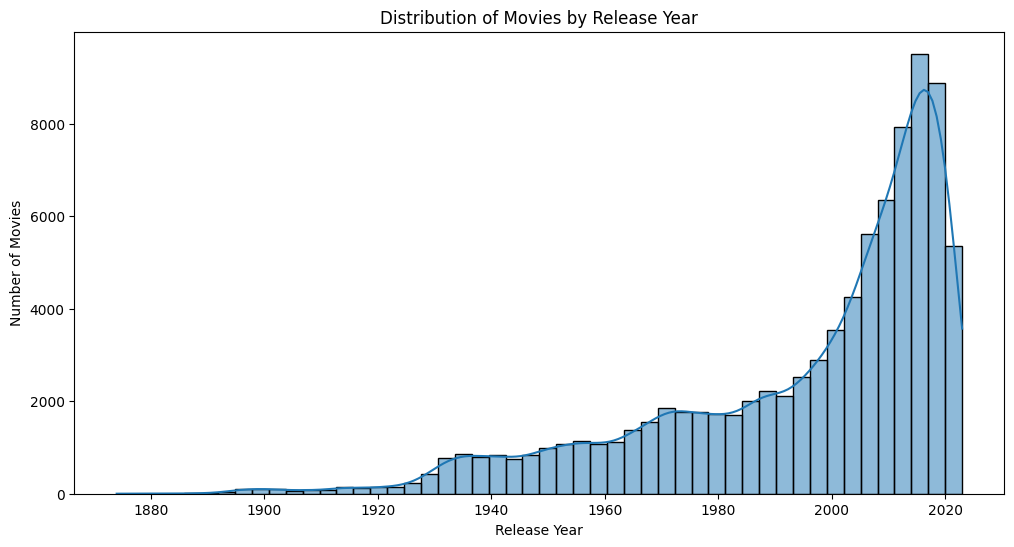

In [11]:
# Extrair o ano de lançamento do título do filme
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

plt.figure(figsize=(12, 6))
sns.histplot(movies_df['year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

### Interpretação do Gráfico: Distribuição de Filmes por Ano de Lançamento

- **Antes de 1950**: Poucos filmes eram lançados, com crescimento lento.
- **1950 a 1980**: A produção aumentou gradualmente.
- **1980 a 2010**: Houve um crescimento acentuado no número de lançamentos.
- **Pico por volta de 2015**: Maior número de filmes lançados.
- **Queda após 2015**: Redução significativa, possivelmente devido à pandemia.

O gráfico mostra a expansão da indústria cinematográfica ao longo do tempo, com uma desaceleração recente.

Em seguida, exploraremos a distribuição de gêneros extraindo-os e contando-os, e então visualizando sua distribuição.

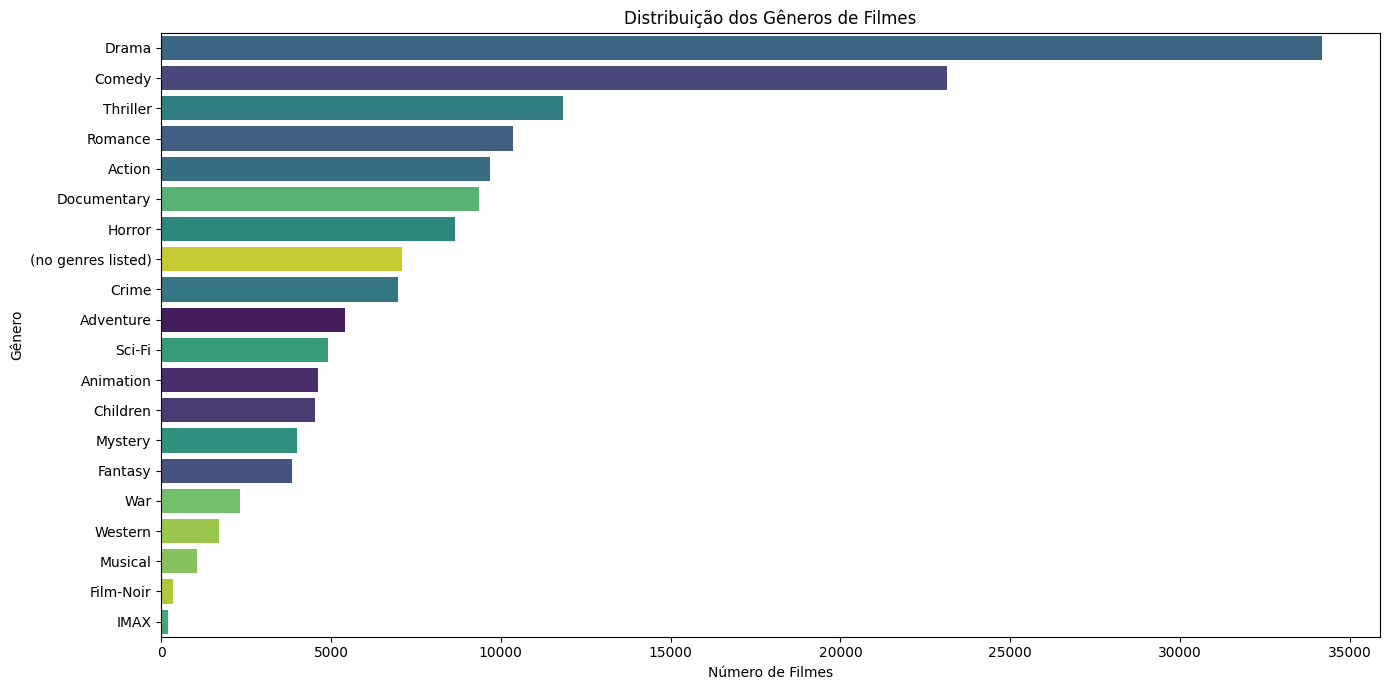

In [12]:
# Explodir a coluna 'genres' para ter uma linha por gênero por filme
genres = movies_df['genres'].str.split('|').explode()

plt.figure(figsize=(14, 7))

sns.countplot(
    y=genres,
    order=genres.value_counts().index,
    hue=genres,
    palette='viridis',
    legend=False
)

plt.title('Distribuição dos Gêneros de Filmes')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.tight_layout()
plt.show()


### Interpretação do Gráfico: Distribuição de Filmes por Gênero

O gráfico mostra a distribuição dos filmes por gênero no conjunto de dados.

É possível observar que os gêneros mais frequentes são:
- **Drama**, que aparece com maior destaque, indicando um forte peso desse tipo de filme na base.
- **Comédia** e **Ação**, que também têm uma representação significativa.

Gêneros como **Guerra**, **Musical** e **Filmes IMAX** aparecem com menos frequência, sugerindo que são menos comuns nesse conjunto.

Essa distribuição pode indicar uma tendência dos usuários ou da própria base de dados a incluir mais obras de certos gêneros, especialmente os mais populares como *Drama* e *Comédia*.

Agora, identificaremos filmes com títulos duplicados ou formatos de títulos incomuns.

In [13]:
# Identificar títulos duplicados
duplicate_titles = movies_df[movies_df.duplicated('title', keep=False)].sort_values('title')
print("Filmes com títulos duplicados:")
display(duplicate_titles)

Filmes com títulos duplicados:


,movieId,title,genres,year
74770,245234,2020 (2020),Comedy,2020.0
71461,230389,2020 (2020),Documentary,2020.0
18413,96456,ATM (2012),Horror|Thriller,2012.0
67307,217057,ATM (2012),Comedy|Romance,2012.0
30796,136696,Absolution (2015),Action|Adventure|Crime|Thriller,2015.0
...,...,...,...,...
17396,91199,Weekend (2011),Drama|Romance,2011.0
57761,195275,White Lily (2016),Drama|Sci-Fi,2016.0
67108,216597,White Lily (2016),Drama,2016.0
81594,274159,Yellow (2006),(no genres listed),2006.0


**Principais problemas encontrados sobre dados duplicados:**
- 401 filmes com títulos repetidos
- Mesmo título com gêneros diferentes (ex: "ATM" como Terror e Comédia)
- Alguns sem informação de gênero

In [14]:
# Remover todas as linhas com títulos duplicados
movies_df = movies_df[~movies_df['title'].isin(duplicate_titles['title'])]

print("DataFrame após remoção dos títulos duplicados:")
display(movies_df)

DataFrame após remoção dos títulos duplicados:


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,2022.0
87581,292737,Shelter in Solitude (2023),Comedy|Drama,2023.0
87582,292753,Orca (2023),Drama,2023.0
87583,292755,The Angry Breed (1968),Drama,1968.0


As linhas com títulos duplicados foram removidas do DataFrame para garantir que cada filme possua um título único. Isso evita inconsistências e ambiguidades nos dados, especialmente em análises ou operações como buscas, agrupamentos e visualizações, onde títulos repetidos poderiam causar confusão ou resultados incorretos.

## Sumarizar as variáveis quantitativas

Vamos calcular as medidas de tendência central (média, mediana, moda) e medidas de dispersão (desvio padrão, variância, valores mínimo e máximo, quartis) para as variáveis quantitativas nos dataframes.

In [15]:
# Variáveis quantitativas nos dataframes: 'rating', 'timestamp' (em ratings_df), 'year' (em movies_df), 'timestamp' (em tags_df)
# Para simplificar, vamos focar nas variáveis numéricas que fazem mais sentido para estas métricas: 'rating' e 'year'.
# Embora 'timestamp' seja numérico, suas métricas de resumo são menos informativas do que sua distribuição temporal.

# Sumário para 'rating' em ratings_df
print("\nSumário da variável 'rating' (ratings_df):")
display(ratings_df['rating'].describe())
print(f"Média de 'rating': {ratings_df['rating'].mean():.2f}")
print(f"Mediana de 'rating': {ratings_df['rating'].median():.2f}")
print(f"Moda de 'rating': {ratings_df['rating'].mode()[0]}")
print(f"Desvio padrão de 'rating': {ratings_df['rating'].std():.2f}")


Sumário da variável 'rating' (ratings_df):


,rating
count,288960.000000
mean,3.537732
std,1.061764
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


Média de 'rating': 3.54
Mediana de 'rating': 3.50
Moda de 'rating': 4.0
Desvio padrão de 'rating': 1.06


### Análise Descritiva das Avaliações (`rating`)

#### Estatísticas Principais
- **Total de avaliações**: 32 milhões  
- **Média**: 3.54 (escala: 0.5 a 5.0)  
- **Mediana**: 3.50  
- **Moda**: 4.0 (*nota mais frequente*)  
- **Desvio padrão**: 1.06 (*dispersão moderada*)  

#### Distribuição
- **25% das notas ≤ 3.0**  
- **50% das notas ≤ 3.5**  
- **75% das notas ≤ 4.0**  
- **Mínima**: 0.5 | **Máxima**: 5.0  

## Explorar as variáveis qualitativas

Vamos explorar as variáveis qualitativas ('genres' em movies_df, 'tag' em tags_df) contando a frequência absoluta e relativa de cada categoria.

In [16]:
print("\nExploração das variáveis qualitativas:")

# Exploração da variável 'genres' em movies_df
print("\nExploração da variável 'genres' (movies_df):")
genres_counts = genres.value_counts() # Reutilizando a variável 'genres' criada anteriormente
genres_freq_abs = genres_counts
genres_freq_rel = genres_counts / genres_counts.sum() * 100

genres_summary_df = pd.DataFrame({
    'Frequência Absoluta': genres_freq_abs,
    'Frequência Relativa (%)': genres_freq_rel
})
display(genres_summary_df)



Exploração das variáveis qualitativas:

Exploração da variável 'genres' (movies_df):


,Frequência Absoluta,Frequência Relativa (%)
genres,,
Drama,34175,22.167088
Comedy,23124,14.999027
Thriller,11823,7.668807
Romance,10369,6.725692
Action,9668,6.271000
Documentary,9363,6.073166
Horror,8654,5.613284
(no genres listed),7080,4.592333
Crime,6976,4.524875


#### Principais Observações:
1. **Gênero dominante**: Drama (23.4% dos filmes)
2. **Top 3 gêneros** (Drama, Comedy, Action) representam **55.8%** do total

In [17]:
# Criar uma tabela de gêneros usando one-hot encoding
genres_dummies = movies_df['genres'].str.get_dummies(sep='|')

# Adicionar a tabela de gêneros ao DataFrame de filmes
movies_df = pd.concat([movies_df, genres_dummies], axis=1)

# Remover a coluna original 'genres'
movies_df = movies_df.drop('genres', axis=1)

In [18]:
display(movies_df.head(10))

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),1995.0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),1995.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),1995.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),1995.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),1995.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
# Junta as tabelas de avaliações (ratings_df) e de filmes (movies_df) usando 'movieId' como chave
df_merged = pd.merge(ratings_df, movies_df, on='movieId')
# Conta quantas avaliações cada usuário fez
user_counts = df_merged['userId'].value_counts()
print("Número de avaliações por usuário:")
display(user_counts)
# Conta quantas avaliações cada filme recebeu
movie_counts = df_merged['movieId'].value_counts()
print("\nNúmero de avaliações por filme:")
display(movie_counts)

Número de avaliações por usuário:


,count
userId,
1048,3515
28,2835
1668,2577
265,2421
1411,2264
...,...
165,20
1761,19
760,19



Número de avaliações por filme:


,count
movieId,
318,952
356,908
296,896
2571,874
593,828
...,...
150523,1
143515,1
128320,1


In [20]:
# Mantém apenas os usuários que avaliaram 50 ou mais filmes
df_merged = df_merged[df_merged['userId'].isin(user_counts[user_counts >= 50].index)]
# Mantém apenas os filmes que receberam 50 ou mais avaliações
df_merged = df_merged[df_merged['movieId'].isin(movie_counts[movie_counts >= 50].index)]
# Exibe as primeiras linhas do DataFrame filtrado
display(df_merged.head())

,userId,movieId,rating,timestamp,title,year,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,17,4.0,1999-12-03 19:24:37,Sense and Sensibility (1995),1995.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,25,1.0,1999-12-03 19:43:48,Leaving Las Vegas (1995),1995.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,29,2.0,1999-11-22 00:36:16,"City of Lost Children, The (Cité des enfants p...",1995.0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,1,32,5.0,1999-11-22 00:00:58,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1995.0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
5,1,34,2.0,1999-11-21 23:54:51,Babe (1995),1995.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Cria uma matriz de usuários x filmes:
# - 'index' define que cada linha será um usuário (userId)
# - 'columns' define que cada coluna será um filme (movieId)
# - 'values' define que o valor na célula será a nota dada (rating)
user_item_matrix = df_merged.pivot(index='userId', columns='movieId', values='rating')
display(user_item_matrix.head(10))


movieId,1,2,3,5,6,7,10,11,14,16,...,182715,185029,187541,187593,195159,202429,202439,204698,207313,208703
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.5,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2.5,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
17,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Descrição do Código usando REGRESSÂO LOGISTICA

O código implementa um **sistema de recomendação** utilizando **Regressão Logística** para prever se um usuário gostará de um filme.

1. **Transformação da variável-alvo**  
   - Cria a coluna binária `liked`: valor **1** se a nota ≥ 4 e **0** caso contrário.

2. **Preparação dos dados**  
   - Define como *features* o `userId`, `movieId` e as colunas de gênero do filme.  
   - Converte `userId` e `movieId` para string e aplica **One-Hot Encoding**.  
   - Divide os dados em treino (80%) e teste (20%), mantendo a proporção da variável-alvo.

3. **Treinamento do modelo**  
   - Utiliza **Regressão Logística** (`solver='liblinear'`) para classificação binária.  
   - Treina o modelo nos dados de treino.

4. **Avaliação do modelo**  
   - Mede **Acurácia** e **AUC-ROC** no conjunto de teste para verificar desempenho.

5. **Função de recomendação**  
   - Para um usuário, identifica filmes não avaliados.  
   - Calcula a probabilidade de “gostar” usando o modelo treinado.  
   - Ordena por probabilidade e retorna os **Top 10** com título e pontuação prevista.


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [23]:
# 1. Transformar as notas em classes (binária: 1 se nota >= 4, 0 se nota < 4)
# Cria uma nova coluna 'liked' que é 1 se a nota for >= 4, e 0 caso contrário.
df_merged['liked'] = (df_merged['rating'] >= 4.0).astype(int)

# 2. Preparar os dados para o modelo de Regressão Logística
# As features serão o userId, o movieId, e as colunas de gênero.
genre_columns = movies_df.columns.drop(['movieId', 'title', 'year']) # Obtém as colunas de gênero do movies_df
features = ['userId', 'movieId'] + list(genre_columns) # Combina as features de usuário, filme e gênero
target = 'liked'

X = df_merged[features].copy() # Cria uma cópia explícita para evitar o aviso SettingWithCopyWarning
y = df_merged[target]

# Converte userId e movieId para string para aplicar one-hot encoding
X['userId'] = X['userId'].astype(str)
X['movieId'] = X['movieId'].astype(str)

# Aplica one-hot encoding em userId e movieId, mantendo as outras features
X_encoded = pd.get_dummies(X, columns=['userId', 'movieId'], drop_first=True)

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Usa os dados originais X_train e X_test diretamente
X_train_model = X_train
X_test_model = X_test

# 3. Treinar o modelo de Regressão Logística
# Inicializa o modelo de Regressão Logística
model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' é adequado para datasets menores e classificação binária

# Treina o modelo com os dados de treino
model.fit(X_train_model, y_train)

# 4. Avaliar o modelo nos dados de teste
# Faz previsões nos dados de teste
y_pred = model.predict(X_test_model)
y_prob = model.predict_proba(X_test_model)[:, 1] # Probabilidade da classe positiva (liked=1)

# Calcula a acurácia e o AUC-ROC
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy on test set: {accuracy:.4f}")
print(f"AUC-ROC on test set: {auc_roc:.4f}")

Accuracy on test set: 0.7136
AUC-ROC on test set: 0.7852


In [24]:
# Função para recomendar filmes para um usuário
def recommend_movies_lr(user_id, model, movies_df, features, n_recommendations=10):
    """
    Recomenda filmes para um determinado usuário usando o modelo de Regressão Logística.

    Args:
        user_id (int): O ID do usuário.
        model: O modelo de Regressão Logística treinado.
        movies_df (pd.DataFrame): DataFrame com informações dos filmes.
        features (list): Lista de features usadas no treinamento do modelo.
        n_recommendations (int): Quantidade de recomendações a retornar.

    Returns:
        pd.DataFrame: DataFrame com os top N filmes recomendados e suas probabilidades previstas de 'gostar'.
    """
    # Obtém todos os IDs de filmes avaliados pelo usuário no dataframe original
    rated_movie_ids = df_merged[df_merged['userId'] == user_id]['movieId'].unique()

    # Obtém todos os filmes não avaliados pelo usuário
    unrated_movies_df = movies_df[~movies_df['movieId'].isin(rated_movie_ids)].copy()

    if unrated_movies_df.empty:
        print(f"Usuário {user_id} avaliou todos os filmes disponíveis.")
        return pd.DataFrame()

    # Prepara os dados para predição
    # Cria um DataFrame com user_id e movieId para filmes não avaliados
    predict_data = unrated_movies_df[['movieId'] + list(genre_columns)].copy()
    predict_data['userId'] = user_id

    # Seleciona as features e converte userId e movieId para string
    X_predict = predict_data[features].copy()
    X_predict['userId'] = X_predict['userId'].astype(str)
    X_predict['movieId'] = X_predict['movieId'].astype(str)

    # Aplica one-hot encoding em userId e movieId nos dados de predição
    X_predict_encoded = pd.get_dummies(X_predict, columns=['userId', 'movieId'])

    # Reindexa os dados de predição para corresponder às colunas dos dados de treino, preenchendo ausentes com 0
    X_predict_encoded = X_predict_encoded.reindex(columns=X_train_model.columns, fill_value=0)

    # Prediz a probabilidade de "gostar" para cada filme não avaliado
    unrated_movies_df['predicted_liked_prob'] = model.predict_proba(X_predict_encoded)[:, 1]

    # Ordena os filmes pela probabilidade prevista (decrescente)
    recommendations = unrated_movies_df.sort_values(by='predicted_liked_prob', ascending=False)

    # Seleciona os top N filmes e inclui o título e a probabilidade prevista
    top_recommendations = recommendations.head(n_recommendations)[['movieId', 'title', 'predicted_liked_prob']]

    return top_recommendations

In [25]:
# Exemplo: Recomendar filmes para um usuário aleatório
random_user = random.choice(df_merged['userId'].unique())
print(f"\nRecomendando filmes para o usuário {random_user}:")

# Passa a lista de features para a função de recomendação
recommendations_lr = recommend_movies_lr(random_user, model, movies_df, features)

if not recommendations_lr.empty:
    print("\nTop 10 recomendações de filmes (Regressão Logística):")
    display(recommendations_lr)


Recomendando filmes para o usuário 47:

Top 10 recomendações de filmes (Regressão Logística):


,movieId,title,predicted_liked_prob
11888,55442,Persepolis (2007),0.946003
314,318,"Shawshank Redemption, The (1994)",0.941984
12600,61236,Waltz with Bashir (Vals im Bashir) (2008),0.938157
1251,1284,"Big Sleep, The (1946)",0.937991
61090,202439,Parasite (2019),0.935941
2867,2959,Fight Club (1999),0.934976
1227,1260,M (1931),0.931519
10704,44555,"Lives of Others, The (Das leben der Anderen) (...",0.928245
6975,7099,Nausicaä of the Valley of the Wind (Kaze no ta...,0.928153
27927,130275,The Life and Mind of Mark DeFriest (2014),0.927448
